In [587]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Example 2: using the outputs of GSN to denoise data ("GSNdenoise")

## Overview
This notebook demonstrates the application of GSNdenoise on fMRI data. 
It includes steps for data preparation, denoising using GSN, and visualization of results.

Users encountering bugs, unexpected outputs, or other issues regarding GSN shouldn't hesitate to raise an issue on GitHub: https://github.com/cvnlab/GSN/issues

The example data has dimensionality 100 voxels x 200 conditions x 3 trials. The data are from an fMRI experiment measuring responses to auditory sentences. The values reflect fMRI response amplitudes in percent BOLD signal change units. The voxels are taken from a brain region in the left hemisphere. 

---

In [642]:
# Import standard libraries for file and path handling
import os
from os.path import join, exists, split
import sys

# Add the GSN project directory to the system path
sys.path.append(f'{os.getcwd()}/../')

# Import GSN-related modules
from gsn.perform_gsn import perform_gsn
from gsn.denoise_data import *

# Import additional libraries for scientific computing and visualization
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

# Utilities for handling web requests and debugging
import urllib.request
import traceback
import pdb


In [643]:
# Define paths for home, data, and output directories
homedir = split(os.getcwd())[0]
datadir = join(homedir, 'examples', 'data')
outputdir = join(homedir, 'examples', 'example2outputs')

# Create directories if they do not exist
os.makedirs(datadir, exist_ok=True)
os.makedirs(outputdir, exist_ok=True)

# Display the configured directories
print(f'Directory to save example dataset:\n\t{datadir}\n')
print(f'Directory to save example outputs:\n\t{outputdir}\n')


Directory to save example dataset:
	/home/jovyan/work/DropboxProjects/GSN/examples/data

Directory to save example outputs:
	/home/jovyan/work/DropboxProjects/GSN/examples/example2outputs



## Download dataset

In [644]:
# Define the file name for the dataset
datafn = join(datadir, 'exampledata.mat')

# Check if the dataset already exists; if not, download it
if not exists(datafn):
    print(f'Downloading example dataset and saving to:\n{datafn}')
    dataurl = 'https://osf.io/download/utfpq/'
    urllib.request.urlretrieve(dataurl, datafn)

# Load the dataset from the .mat file
X = sio.loadmat(datafn)


In [645]:
# The dataset contains 100 voxels x 200 conditions x 3 trials
# Split data into training (even indices) and testing (odd indices)
train_data = X['data'].copy()[:, ::2]
test_data = X['data'].copy()[:, 1::2]

# Extract dataset dimensions
nvox, ncond, ntrial = train_data.shape
print(f"Number of voxels: {nvox}, conditions: {ncond}, trials: {ntrial}")


Number of voxels: 100, conditions: 100, trials: 3


## Perform GSN

In [646]:
# Perform GSN denoising on training data with shrinkage enabled
results = perform_gsn(train_data.copy(), {'wantshrinkage': True})


Estimating noise covariance...done.
Estimating data covariance...done.
Estimating signal covariance...done.
Performing biconvex optimization...done.
Performing Monte Carlo simulations...done.


/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


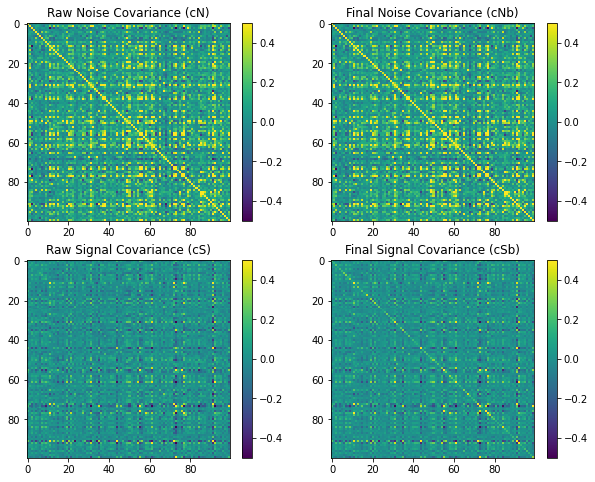

In [647]:
# Define the range for color limits in visualizations
rng = [-0.5, 0.5]

# Create a figure for visualizing covariance estimates
plt.figure(figsize=(10, 8))

# Noise covariance estimate
plt.subplot(2, 2, 1)
plt.imshow(results['cN'], vmin=rng[0], vmax=rng[1], aspect='auto', interpolation='none')
plt.colorbar()
plt.title('Raw Noise Covariance (cN)')

# Final noise covariance estimate
plt.subplot(2, 2, 2)
plt.imshow(results['cNb'], vmin=rng[0], vmax=rng[1], aspect='auto', interpolation='none')
plt.colorbar()
plt.title('Final Noise Covariance (cNb)')

# Signal covariance estimate
plt.subplot(2, 2, 3)
plt.imshow(results['cS'], vmin=rng[0], vmax=rng[1], aspect='auto', interpolation='none')
plt.colorbar()
plt.title('Raw Signal Covariance (cS)')

# Final signal covariance estimate
plt.subplot(2, 2, 4)
plt.imshow(results['cSb'], vmin=rng[0], vmax=rng[1], aspect='auto', interpolation='none')
plt.colorbar()
plt.title('Final Signal Covariance (cSb)')

plt.show()


In [617]:
# We have several outputs in results:
# mnN is the mean of the noise distribution
# cN is the raw estimate of the covariance of the noise distribution 
# cNb is the final estimate of the covariance of the noise distribution
# mnS is the mean of the signal distribution
# cS is the raw estimate of the covariance of the signal distribution 
# cSb is the final estimate of the covariance of the signal distribution
# shrinklevelN is the shrinkage fraction used when estimating the noise distribution
# shrinklevelD is the shrinkage fraction used when estimating the data distribution
# ncsnr is the noise ceiling snr for each voxel (signal sd divided by noise sd)

## Use estimated signal covariance to compute a basis for denoising

In [649]:
# Perform eigendecomposition for the chosen (signal) basis
basis = 'cSb'
S, V = np.linalg.eigh(results[basis])
idx = np.flip(np.argsort(S))
S = S[idx]
V = V[:, idx]

## Compute the denoising matrix

In [650]:
# Configure options for the denoiser
opt = {
    'threshold_per': 'population',
    'scoring_fn': mse_column_loss,
    'thresholds': np.arange(nvox),
    'cv_mode': 0
}

# Compute the optimal denoiser based on cross-validation
denoiser, cv_scores, best_threshold = compute_denoiser(train_data.copy(), V.copy(), opt)


## Apply the denoising matrix to held-out data

In [651]:
# Apply the computed denoiser to the test data
denoised_data, denoiser_out, noise, ncsnrs, ncs = apply_denoiser(
    test_data.copy(), denoiser, rescue=False
)

# Verify that the original data is reconstructable from denoised data and noise
assert np.allclose(test_data.mean(2), denoised_data.mean(2) + noise.mean(2))


## Diagnostic plots

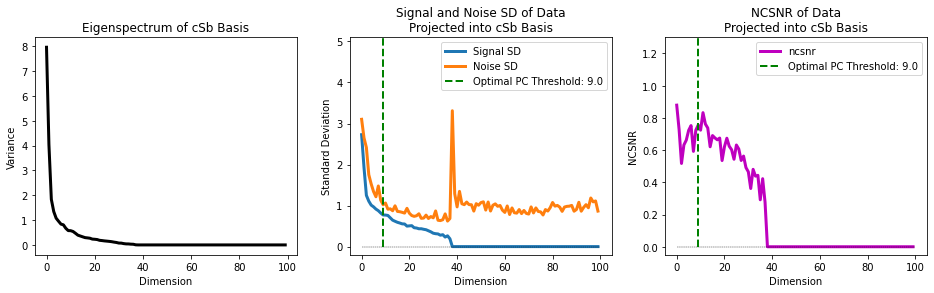

In [652]:
# Plot eigenspectrum and NCSNR
plt.figure(figsize=(16, 4))
plt.subplot(131)
plt.plot(S, linewidth=3, color='k')
plt.title(f'Eigenspectrum of {basis} Basis')
plt.xlabel('Dimension')
plt.ylabel('Variance')

plot_basis_dim_ncsnrs(
    train_data.copy().transpose(1, 2, 0), V, basis, best_threshold, subplots=(132, 133)
)


Text(0.5, 1.0, 'cSb: cross-validation scores per voxel/threshold')

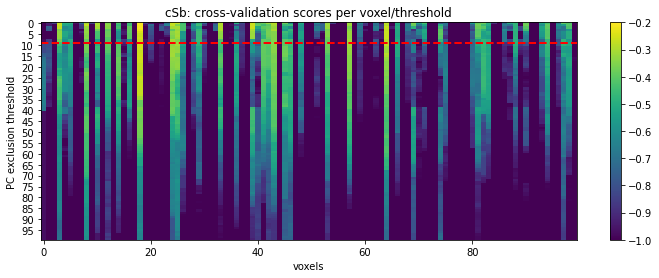

In [653]:
# Create a figure to visualize cross-validation scores per voxel/threshold
plt.figure(figsize=(12, 4))

# Plot the mean cross-validation scores for each threshold
plt.imshow(cv_scores.mean(1), aspect='auto', interpolation='none', clim=(-1, -0.2))

# Set y-axis ticks to display thresholds every 5 steps
plt.yticks(np.arange(len(opt['thresholds']))[::5], np.array(opt['thresholds'])[::5])

# Add a red dashed line to indicate the optimal threshold
if opt['threshold_per'] == 'population':
    # For population-based thresholding
    plt.plot([-0.5, nvox + 0.5], [best_threshold.mean(), best_threshold.mean()], 'r--', linewidth=2)
elif opt['threshold_per'] == 'unit':
    # For unit-based thresholding
    plt.plot(np.arange(nvox), best_threshold, 'ro-', linewidth=1)

# Set plot limits for x-axis
plt.xlim([-0.5, nvox - 0.5])

# Add colorbar for the heatmap
plt.colorbar()

# Add axis labels and title
plt.xlabel('voxels')
plt.ylabel('PC exclusion threshold')
plt.title(f'{basis}: cross-validation scores per voxel/threshold')


Text(0.5, 1.0, 'Optimal Denoising Matrix')

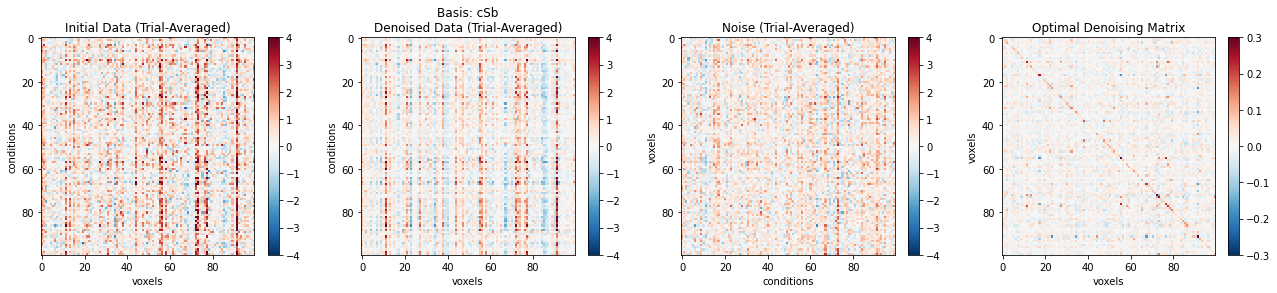

In [654]:
# Create a figure to compare the initial data, denoised data, noise, and denoising matrix
plt.figure(figsize=(22, 4))

# Plot trial-averaged initial data
plt.subplot(141)
plt.imshow(test_data.mean(2).T, aspect='auto', interpolation='none', clim=(-4, 4), cmap='RdBu_r')
plt.colorbar()
plt.title('Initial Data (Trial-Averaged)')
plt.xlabel('voxels')
plt.ylabel('conditions')

# Plot trial-averaged denoised data
plt.subplot(142)
plt.imshow(denoised_data.mean(2).T, aspect='auto', interpolation='none', clim=(-4, 4), cmap='RdBu_r')
plt.colorbar()
plt.title(f'Basis: {basis}\nDenoised Data (Trial-Averaged)')
plt.xlabel('voxels')
plt.ylabel('conditions')

# Plot trial-averaged noise
plt.subplot(143)
plt.imshow(noise.mean(2).T, aspect='auto', interpolation='none', clim=(-4, 4), cmap='RdBu_r')
plt.colorbar()
plt.xlabel('conditions')
plt.ylabel('voxels')
plt.title('Noise (Trial-Averaged)')

# Plot the optimal denoising matrix
plt.subplot(144)
plt.imshow(denoiser, aspect='auto', interpolation='none', clim=(-0.3, 0.3), cmap='RdBu_r')
plt.colorbar()
plt.xlabel('voxels')
plt.ylabel('voxels')
plt.title('Optimal Denoising Matrix')


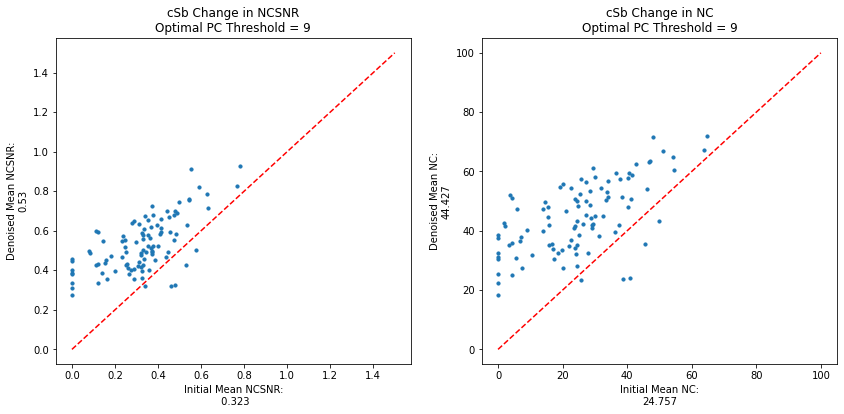

In [655]:
# Create a figure to visualize changes in NCSNR and NC after denoising
plt.figure(figsize=(14, 6))

# Scatter plot of initial vs. denoised NCSNR
plt.subplot(121)
plt.scatter(ncsnrs[0], ncsnrs[-1], 10)  # Scatter points
plt.xlabel(f'Initial Mean NCSNR:\n {round(np.nanmean(ncsnrs[0]), 3)}')  # X-axis label
plt.ylabel(f'Denoised Mean NCSNR:\n{round(np.nanmean(ncsnrs[-1]), 3)}')  # Y-axis label
plt.plot([0, 1.5], [0, 1.5], 'r--')  # Red dashed line for reference

# Add a title indicating the optimal PC threshold
if opt['threshold_per'] == 'population':
    plt.title(f'{basis} Change in NCSNR\nOptimal PC Threshold = {best_threshold}')
else:
    plt.title(f'{basis} Change in NCSNR\nOptimal PC Threshold = {best_threshold.mean()}')

# Scatter plot of initial vs. denoised NC
plt.subplot(122)
plt.scatter(ncs[0], ncs[-1], 10)  # Scatter points
plt.xlabel(f'Initial Mean NC:\n{round(np.nanmean(ncs[0]), 3)}')  # X-axis label
plt.ylabel(f'Denoised Mean NC:\n{round(np.nanmean(ncs[-1]), 3)}')  # Y-axis label
plt.plot([0, 100], [0, 100], 'r--')  # Red dashed line for reference

# Add a title indicating the optimal PC threshold
if opt['threshold_per'] == 'population':
    plt.title(f'{basis} Change in NC\nOptimal PC Threshold = {best_threshold}')
else:
    plt.title(f'{basis} Change in NC\nOptimal PC Threshold = {best_threshold.mean()}')


In [656]:
# Compute the Pearson correlation between pairwise distances in the data and noise
stats.pearsonr(
    pdist(test_data.mean(2).T, 'correlation'),  # Pairwise distances of the trial-averaged test data
    pdist(noise.mean(2).T, 'correlation')      # Pairwise distances of the trial-averaged noise
)


(0.6287597894432114, 0.0)